<a href="https://colab.research.google.com/github/souza-dev/bigdata/blob/main/ProjetoFinalBigdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Projeto final: Big Data e Processamento Distribuído_

Alunos: <br>
Thiago Augusto de Souza <br>
Luiz Gustavo de Souza

Dataset utilizado: 
https://www.kaggle.com/vikasukani/loan-eligible-dataset?select=loan-train.csv



#Configurações necessárias para que o Spark rode no Google Collab

In [1]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

#Importação das bibliotecas e configuração do projeto

In [1]:
import findspark
findspark.init('spark-3.2.0-bin-hadoop3.2')
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

import pyspark.sql.functions as F
from pyspark.ml.feature import Imputer

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier

import warnings
warnings.filterwarnings("ignore")

sc = pyspark.SparkContext(appName='projetobigdata')
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
sns.set_theme()

In [5]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: loan-test.csv           
  inflating: loan-train.csv          


Para a análise exploratória dos dados, unimos os dados de treino e de teste.

In [2]:
loan_df_train = spark.read.csv('/content/loan-train.csv', inferSchema=True, header=True)
loan_df_test = spark.read.csv('/content/loan-test.csv', inferSchema=True, header=True)
loan_df = loan_df_train.unionByName(loan_df_test, allowMissingColumns=True)
loan_df.count()

981

# Análise preliminar dos dados

Em uma análise prelimiar dos dados, vamos retirar a coluna Loan_ID que não será necessária para o aprendizado de máquinas e vamos verificar a existência de linhas com valores nulos.

In [3]:
loan_df = loan_df.drop('Loan_ID') 

In [4]:
loan_df.select([count(when(col(c).isNull(), c)).alias(c) for c in loan_df.columns]).show()

+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|    24|      3|        25|        0|           55|              0|                0|        27|              20|            79|            0|        367|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [5]:
loan_df.summary().show()

+-------+------+-------+------------------+------------+-------------+-----------------+------------------+------------------+-----------------+------------------+-------------+-----------+
|summary|Gender|Married|        Dependents|   Education|Self_Employed|  ApplicantIncome| CoapplicantIncome|        LoanAmount| Loan_Amount_Term|    Credit_History|Property_Area|Loan_Status|
+-------+------+-------+------------------+------------+-------------+-----------------+------------------+------------------+-----------------+------------------+-------------+-----------+
|  count|   957|    978|               956|         981|          926|              981|               981|               954|              961|               902|          981|        614|
|   mean|  null|   null|0.5549132947976878|        null|         null|5179.795107033639|1601.9163302636496|142.51153039832286|342.2018730489074| 0.835920177383592|         null|       null|
| stddev|  null|   null|0.7859012419823703|       

Como estratégia para lidar com os valores nulos, foi escolhido substituir esses valores pela moda estatística nas colunas `Loan_Amount_Term` e `Credit_History` e pela média aritmética para aa coluna `LoanAmount`.

In [6]:
imputer = Imputer(inputCols=['Loan_Amount_Term', 'Credit_History'], outputCols=['Loan_Amount_Term', 'Credit_History']).setStrategy('mode')
loan_df = imputer.fit(loan_df).transform(loan_df)

imputer = Imputer(inputCols=['LoanAmount'], outputCols=['LoanAmount']).setStrategy('mean')
loan_df = imputer.fit(loan_df).transform(loan_df)

loan_df.select([count(when(col(c).isNull(), c)).alias(c) for c in loan_df.columns]).show()

+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|    24|      3|        25|        0|           55|              0|                0|         0|               0|             0|            0|        367|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



Para as outras colunas que possui valores nulos e não numéricos, inserimos o valor que aparece mais frequentemente.

In [7]:
for col_name in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Status']:
    common = loan_df.dropna().groupBy(col_name).agg(F.count("*")).orderBy('count(1)', ascending=False).first()[col_name]
    loan_df = loan_df.withColumn(col_name, F.when(F.isnull(col_name), common).otherwise(loan_df[col_name]))

loan_df.select([count(when(col(c).isNull(), c)).alias(c) for c in loan_df.columns]).show()

+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|          0|
+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+



In [8]:
loan_df.groupBy('Gender').count().show()
loan_df.groupBy('Married').count().show()
loan_df.groupBy('Dependents').count().show()
loan_df.groupBy('Education').count().show()
loan_df.groupBy('Self_Employed').count().show()
loan_df.groupBy('Property_Area').count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female|  182|
|  Male|  799|
+------+-----+

+-------+-----+
|Married|count|
+-------+-----+
|     No|  347|
|    Yes|  634|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|         0|  570|
|         1|  160|
|        3+|   91|
|         2|  160|
+----------+-----+

+------------+-----+
|   Education|count|
+------------+-----+
|Not Graduate|  218|
|    Graduate|  763|
+------------+-----+

+-------------+-----+
|Self_Employed|count|
+-------------+-----+
|           No|  862|
|          Yes|  119|
+-------------+-----+

+-------------+-----+
|Property_Area|count|
+-------------+-----+
|        Urban|  342|
|    Semiurban|  349|
|        Rural|  290|
+-------------+-----+



Verificado a não existência mais de valores nulos, foi feito a análise exploratória dos dados.

# Análise exploratória dos dados

Para inícios da exploração dos dados vamos criar uma coluna com `ApplicantIncomeTotal` como a soma das colunas `ApplicantIncome` e `CoapplicantIncome` e analisar como se comporta a renda total como a soma das duas colunas consideradas.

In [9]:
loan_df = loan_df.withColumn("ApplicantIncomeTotal", col('ApplicantIncome') + col('CoapplicantIncome'))
loan_pd = loan_df.toPandas()

### Variáveis contínuas

Foi feita uma análise das variáveis continuas nas colunas `ApplicantIncome`,  `CoapplicantIncome` e `LoanAmount`

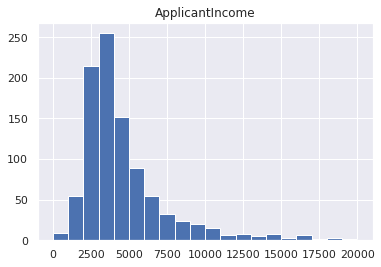

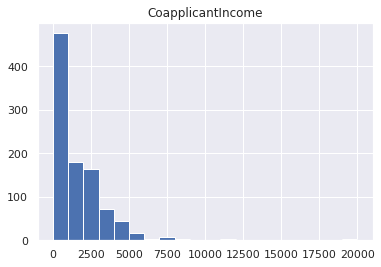

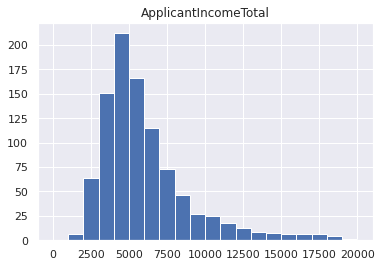

In [10]:
loan_pd.hist(bins=20, column=['ApplicantIncome'], range=[0, 20000])
plt.show()
loan_pd.hist(bins=20, column=['CoapplicantIncome'], range=[0, 20000])
plt.show()
loan_pd.hist(bins=20, column=['ApplicantIncomeTotal'], range=[0, 20000])
plt.show()

Foi possível verificar que existe uma grande quantidade de dados de usuários que possui 0 como valor da coluna `'CoapplicantIncome`. Porém considerar a soma das rendas uniformiza melhor os dados, indicando que talvez seja melhor considerar a soma das rendas no lugar de duas colunas de rendas separadas. 

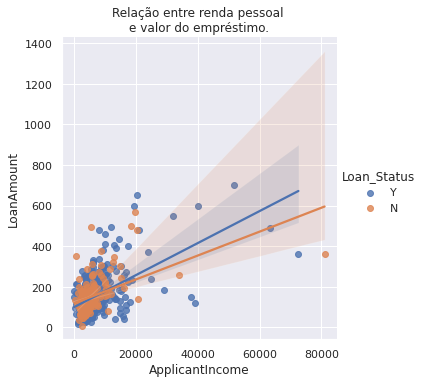

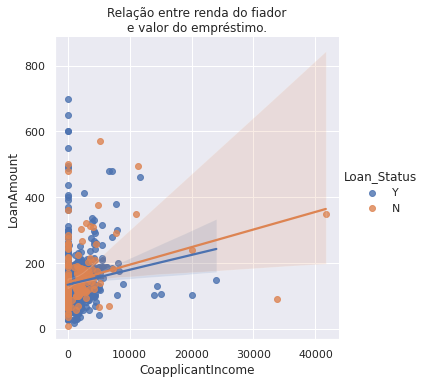

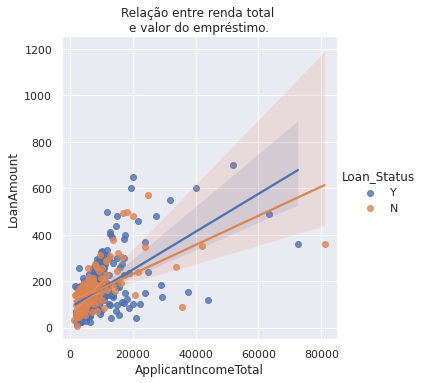

In [11]:
sns.lmplot(x='ApplicantIncome', y='LoanAmount', data=loan_pd, hue='Loan_Status').set(title="Relação entre renda pessoal \ne valor do empréstimo.")
plt.show()
sns.lmplot(x='CoapplicantIncome', y='LoanAmount', data=loan_pd, hue='Loan_Status').set(title="Relação entre renda do fiador\ne valor do empréstimo.")
plt.show()
sns.lmplot(x='ApplicantIncomeTotal', y='LoanAmount', data=loan_pd, hue='Loan_Status').set(title="Relação entre renda total \ne valor do empréstimo.")
plt.show()


Nota-se que os empréstimos aceitos tem uma relação mais linear com a renda do que os empréstimos que foram negados.

In [12]:
r1, _ = sp.stats.pearsonr(loan_pd['ApplicantIncome'], loan_pd['LoanAmount'])
r2, _ = sp.stats.pearsonr(loan_pd['CoapplicantIncome'], loan_pd['LoanAmount'])
r3, _ = sp.stats.pearsonr(loan_pd['ApplicantIncomeTotal'], loan_pd['LoanAmount'])

print('R da relação entre ApplicationIncome e LoanAmout: {:.2f}'.format(r1))
print('R da relação entre CoapplicantIncome e LoanAmout: {:.2f}'.format(r2))
print('R da relação entre ApplicantIncomeTotal e LoanAmout: {:.2f}'.format(r3))

R da relação entre ApplicationIncome e LoanAmout: 0.55
R da relação entre CoapplicantIncome e LoanAmout: 0.18
R da relação entre ApplicantIncomeTotal e LoanAmout: 0.60


E que somar as colunas `ApplicationIncome` e `CoapplicantIncome` aumenta a correlação com a variável da coluna `LoanAmount`

[Text(0.5, 1.0, 'Relação entre renda Loan_Amount_Term. R = 0.05')]

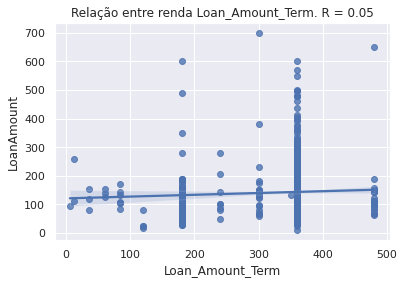

In [13]:
r, _ = sp.stats.pearsonr(loan_pd['Loan_Amount_Term'], loan_pd['LoanAmount'])
sns.regplot(x='Loan_Amount_Term', y='LoanAmount', data=loan_pd).set(title="Relação entre renda Loan_Amount_Term. R = {:.2f}".format(r))


Já os dados de `Loan_Amount_Term` não mostrou nenhuma correlação com o `Loan_Amount`

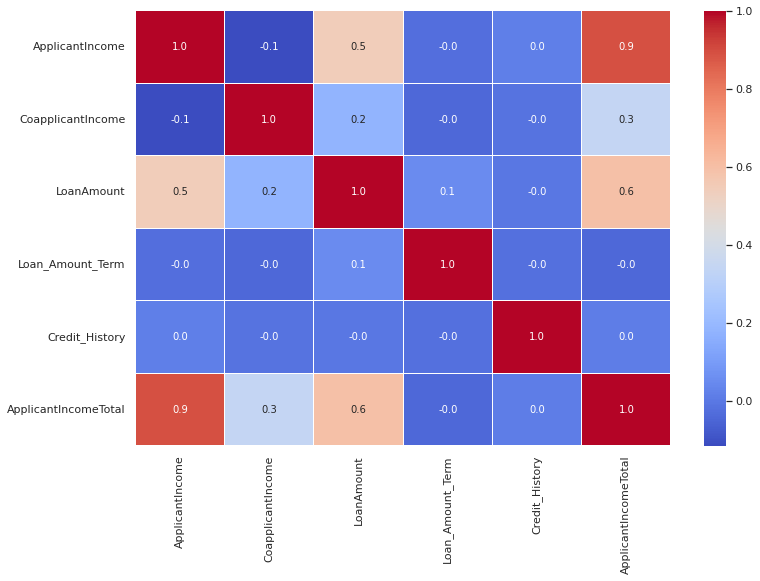

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(loan_pd.corr(), cmap='coolwarm', annot=True, fmt='.1f', linewidths=.1)
plt.show()

Como verificamos que a coluna de `ApplicantIncomeTotal`tem uma forte correlação com a soma das coluna `ApplicationIncome` e `CoapplicantIncome`, então podemos dispensar essas duas últimas em favorecimento da soma delas durante a fase do aprendizado de máquina. 

## Variáveis discretas
Através de gráficos de barras podemos analisar a relação da aprovação ou não do crédito com as variaveis discretas das colunas `Credit_History`, `Property_Area`, `Self_Employed`, `Education`, `Dependents`, `Married` e `Gender`.


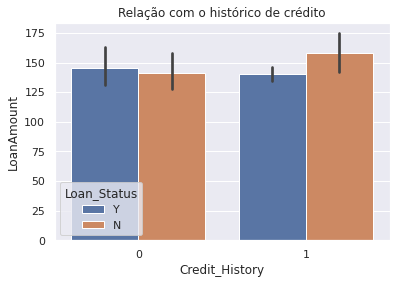

In [15]:
sns.barplot(x='Credit_History', y='LoanAmount', hue='Loan_Status', data=loan_pd).set(title='Relação com o histórico de crédito')
plt.show()

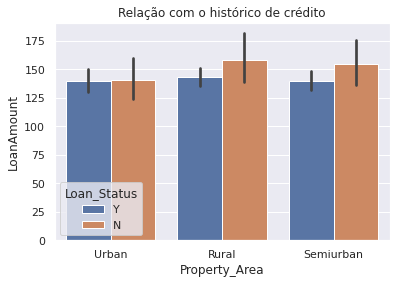

In [16]:
sns.barplot(x='Property_Area', y='LoanAmount', hue='Loan_Status', data=loan_pd).set(title='Relação com o histórico de crédito')
plt.show()

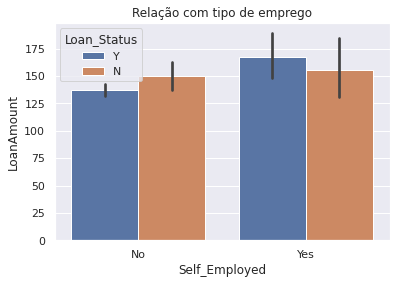

In [17]:
sns.barplot(x='Self_Employed', y='LoanAmount', hue='Loan_Status', data=loan_pd).set(title='Relação com tipo de emprego')
plt.show()

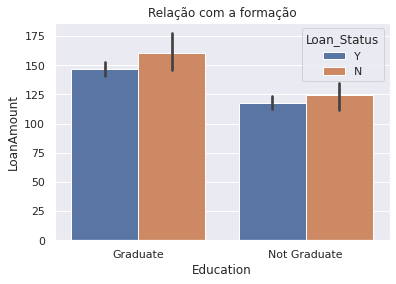

In [18]:
sns.barplot(x='Education', y='LoanAmount', hue='Loan_Status', data=loan_pd).set(title='Relação com a formação')
plt.show()

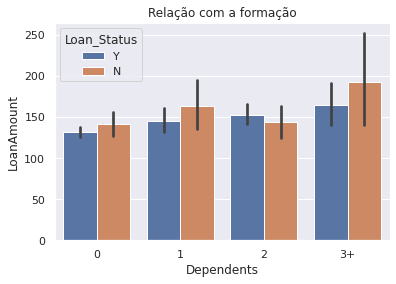

In [19]:
sns.barplot(x='Dependents', y='LoanAmount', hue='Loan_Status', data=loan_pd).set(title='Relação com a formação')
plt.show()

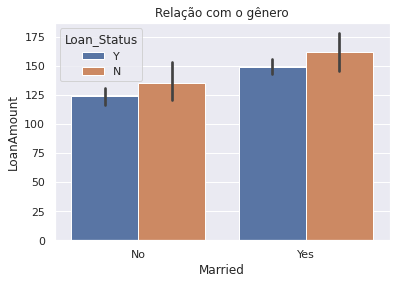

In [20]:
sns.barplot(x='Married', y='LoanAmount', hue='Loan_Status', data=loan_pd).set(title='Relação com o gênero')
plt.show()

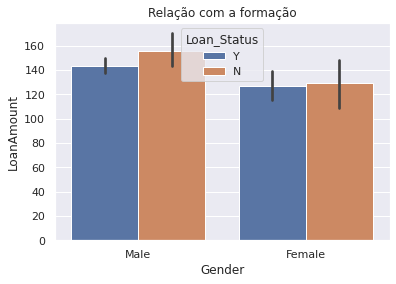

In [21]:
sns.barplot(x='Gender', y='LoanAmount', hue='Loan_Status', data=loan_pd).set(title='Relação com a formação')
plt.show()

A princípio a análise dos dados categóricos mostra que as colunas `Dependents` e `Property_Area`tem maior influência na varável alvo `Loan_Status`

#Aprendizado de máquina

Feita a análise preliminar, partimos para o aprendizado de máquina. Optou-se por manter a coluna `ApplicationIncomeTotal` e não utilizar as colunas `ApplicantIcome` e `CoapplicantIncome`. Todas as outras colunas, incluindo as que possuem dados categoricos serão mantidas.

Primeiro serão feito o tratamento de dados e um modelo de DecisionTree será compilado como teste. Sendo feito isso, outros modelos serão rodados utilizando Pipeline e os hiperparâmetos serão otimizados através do Gridsearch e Crossvalidator. 

In [22]:
loan_df.show(10)

+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+--------------------+
|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|ApplicantIncomeTotal|
+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+--------------------+
|  Male|     No|         0|    Graduate|           No|           5849|              0.0|       142|             360|             1|        Urban|          Y|              5849.0|
|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|              6091.0|
|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|      

A primeira coisa que vamos fazer, é transformar a coluna alvo para numérica e adiciona como uma coluna `Y_bin`

In [23]:
loan_df = loan_df.withColumn('Y_bin', F.when(loan_df['Loan_Status'] == 'Y', 1).otherwise(0))
loan_df.select('Loan_Status', 'Y_bin').show(10)

+-----------+-----+
|Loan_Status|Y_bin|
+-----------+-----+
|          Y|    1|
|          N|    0|
|          Y|    1|
|          Y|    1|
|          Y|    1|
|          Y|    1|
|          Y|    1|
|          N|    0|
|          Y|    1|
|          N|    0|
+-----------+-----+
only showing top 10 rows



Normalizando os dados


In [24]:
def min_max_norm(df, cols):
  for col in cols:
    max_value = df.agg({col:'max'}).collect()[0][0]
    min_value = df.agg({col:'min'}).collect()[0][0]
    new_column = col+'_scaled'
    df = df.withColumn(new_column, (df[col] - min_value) / (max_value - min_value))
  return df

columns_to_scale = ['ApplicantIncomeTotal', 'LoanAmount', 'Loan_Amount_Term']
loan_df_scaled = min_max_norm(loan_df, columns_to_scale)
loan_df_scaled.describe('ApplicantIncomeTotal_scaled', 'LoanAmount_scaled', 'Loan_Amount_Term_scaled').show()

+-------+---------------------------+-------------------+-----------------------+
|summary|ApplicantIncomeTotal_scaled|  LoanAmount_scaled|Loan_Amount_Term_scaled|
+-------+---------------------------+-------------------+-----------------------+
|  count|                        981|                981|                    981|
|   mean|        0.06711721558230835|0.19319457536905996|      0.710052172716211|
| stddev|          0.075717747434071|0.11048888003720561|     0.1360379977551073|
|    min|                        0.0|                0.0|                    0.0|
|    max|                        1.0|                1.0|                    1.0|
+-------+---------------------------+-------------------+-----------------------+



Utilizando o StringIndexer nos dados categoricos que são strings.

In [25]:
cols_cat = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
cols_idx = ['Gender_idx', 'Married_idx', 'Dependents_idx', 'Education_idx', 'Self_Employed_idx', 'Property_Area_idx']

indexer = StringIndexer(inputCols=cols_cat, outputCols=cols_idx )
loan_df_si = indexer.fit(loan_df_scaled).transform(loan_df_scaled)
loan_df_si.select(cols_idx).show(10)

+----------+-----------+--------------+-------------+-----------------+-----------------+
|Gender_idx|Married_idx|Dependents_idx|Education_idx|Self_Employed_idx|Property_Area_idx|
+----------+-----------+--------------+-------------+-----------------+-----------------+
|       0.0|        1.0|           0.0|          0.0|              0.0|              1.0|
|       0.0|        0.0|           1.0|          0.0|              0.0|              2.0|
|       0.0|        0.0|           0.0|          0.0|              1.0|              1.0|
|       0.0|        0.0|           0.0|          1.0|              0.0|              1.0|
|       0.0|        1.0|           0.0|          0.0|              0.0|              1.0|
|       0.0|        0.0|           2.0|          0.0|              1.0|              1.0|
|       0.0|        0.0|           0.0|          1.0|              0.0|              1.0|
|       0.0|        0.0|           3.0|          0.0|              0.0|              0.0|
|       0.

Usando o onehot encoder nas variáveis categóricas.

In [26]:
cols_idx_full = cols_idx + ['Credit_History'] #adicionando o Credit_History que não foi passado pelo String Indexer poque ele é Integer
cols_oh = ['Gender_oh', 'Married_oh', 'Dependents_oh', 'Education_oh', 'Self_Employed_oh', 'Property_Area_oh', 'Credit_History_oh']

onehot = OneHotEncoder(inputCols=cols_idx_full, outputCols=cols_oh)
loan_df_oh = onehot.fit(loan_df_si).transform(loan_df_si)
loan_df_oh.select(cols_oh).show(10)

+-------------+-------------+-------------+-------------+----------------+----------------+-----------------+
|    Gender_oh|   Married_oh|Dependents_oh| Education_oh|Self_Employed_oh|Property_Area_oh|Credit_History_oh|
+-------------+-------------+-------------+-------------+----------------+----------------+-----------------+
|(1,[0],[1.0])|    (1,[],[])|(3,[0],[1.0])|(1,[0],[1.0])|   (1,[0],[1.0])|   (2,[1],[1.0])|        (1,[],[])|
|(1,[0],[1.0])|(1,[0],[1.0])|(3,[1],[1.0])|(1,[0],[1.0])|   (1,[0],[1.0])|       (2,[],[])|        (1,[],[])|
|(1,[0],[1.0])|(1,[0],[1.0])|(3,[0],[1.0])|(1,[0],[1.0])|       (1,[],[])|   (2,[1],[1.0])|        (1,[],[])|
|(1,[0],[1.0])|(1,[0],[1.0])|(3,[0],[1.0])|    (1,[],[])|   (1,[0],[1.0])|   (2,[1],[1.0])|        (1,[],[])|
|(1,[0],[1.0])|    (1,[],[])|(3,[0],[1.0])|(1,[0],[1.0])|   (1,[0],[1.0])|   (2,[1],[1.0])|        (1,[],[])|
|(1,[0],[1.0])|(1,[0],[1.0])|(3,[2],[1.0])|(1,[0],[1.0])|       (1,[],[])|   (2,[1],[1.0])|        (1,[],[])|
|(1,[0],[1

Usando o vector assembler para preparar os dados no formato que os algoritmos de machine learning do Spark utiliza.


In [27]:
cols_to_use = ['ApplicantIncomeTotal_scaled','Loan_Amount_Term_scaled', 'Loan_Amount_Term_scaled', 'Gender_oh', 'Married_oh', 'Dependents_oh', 'Education_oh', 'Self_Employed_oh' , 'Property_Area_oh' ]

vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
loan_df_vec = vec.transform(loan_df_oh)
loan_df_vec.select('features', 'Y_bin').show(truncate=False)

+-------------------------------------------------------------------------------------------------+-----+
|features                                                                                         |Y_bin|
+-------------------------------------------------------------------------------------------------+-----+
|[0.05539354936021519,0.7468354430379747,0.7468354430379747,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0]  |1    |
|[0.058435355338243795,0.7468354430379747,0.7468354430379747,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0] |0    |
|[0.01958319716433294,0.7468354430379747,0.7468354430379747,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0]  |1    |
|[0.04398049221951281,0.7468354430379747,0.7468354430379747,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0]  |1    |
|[0.05729153573493552,0.7468354430379747,0.7468354430379747,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0]  |1    |
|[0.10270494482013122,0.7468354430379747,0.7468354430379747,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0]  |1    |
|[0.030254656979813468,0.7468354430379747,0.74

## Primeiro teste de aprendizado de máquina: DecisionTree

In [28]:
loan_train, loan_test = loan_df_vec.randomSplit([0.8,0.2], seed=42)

dt = DecisionTreeClassifier(featuresCol='features', labelCol='Y_bin')
preds_dt_loan = dt.fit(loan_train).transform(loan_test)
preds_dt_loan.select('Y_bin', 'prediction', 'probability').show(truncate=False)

+-----+----------+----------------------------------------+
|Y_bin|prediction|probability                             |
+-----+----------+----------------------------------------+
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|0    |0.0       |[1.0,0.0]                               |
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|0    |1.0       |[0.18823529411764706,0.8117647058823529]|
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|0    |1.0       |[0.18823529411764706,0.8117647058823529]|
|0    |1.0       |[0.18823529411764706,0.8117647058823529]|
|1    |1.0       |[0.18823529411764706,0.8117647058823529]|
|1    |0.0       |[1.0,0.0]             

In [29]:
print('Matriz de confusão')
preds_dt_loan.groupBy('Y_bin', 'prediction').count().show()

Matriz de confusão
+-----+----------+-----+
|Y_bin|prediction|count|
+-----+----------+-----+
|    1|       0.0|    1|
|    0|       0.0|    1|
|    1|       1.0|  141|
|    0|       1.0|   28|
+-----+----------+-----+



In [30]:
multi_eval = MulticlassClassificationEvaluator().setLabelCol('Y_bin')
prec_dt__loan = multi_eval.evaluate(preds_dt_loan, {multi_eval.metricName: 'weightedPrecision'})
recall_dt_loan = multi_eval.evaluate(preds_dt_loan, {multi_eval.metricName: 'weightedRecall'})

bin_eval = BinaryClassificationEvaluator().setLabelCol('Y_bin')
AUC_dt_loan = bin_eval.evaluate(preds_dt_loan, {bin_eval.metricName:'areaUnderROC'})

print(f'Precision: {prec_dt__loan}')
print(f'Recall: {recall_dt_loan}')
print(f'AUC: {AUC_dt_loan }')

Precision: 0.7776220630471643
Recall: 0.8304093567251463
AUC: 0.5240407965031569


# Usando o gridsearch para procurar melhores parâmetros

# DecisionTree


In [51]:
#dividindo novamente os dados para passar pelo pipeline. 
loan_train, loan_test = loan_df_scaled.randomSplit([0.8,0.2], seed=42)

#construindo o pipeline
indexer = StringIndexer(inputCols=cols_cat, outputCols=cols_idx)
onehot = OneHotEncoder(inputCols=cols_idx_full, outputCols=cols_oh)
vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Y_bin')
pipe_loan = Pipeline(stages=[indexer,onehot,vec,dt])

param_grid_loan = ParamGridBuilder() \
                    .addGrid(dt.maxDepth, [5,10, 15]) \
                    .addGrid(dt.maxBins, [16, 32]) \
                    .addGrid(dt.minInstancesPerNode, [1,2]) \
                    .build()

auc_eval = BinaryClassificationEvaluator().setLabelCol('Y_bin')

cv_loan = CrossValidator(estimator=pipe_loan,
                       estimatorParamMaps=param_grid_loan,
                       evaluator=auc_eval,
                       numFolds=5)

cv_loan_model = cv_loan.fit(loan_train)
cv_loan_model.bestModel.stages[3].extractParamMap()
print(auc_eval.evaluate(cv_loan_model.transform(loan_test)))

0.6607576493443419


## Logistic Regression

In [37]:
#dividindo novamente os dados para passar pelo pipeline. 
loan_train, loan_test = loan_df_scaled.randomSplit([0.8,0.2], seed=42)

#construindo o pipeline
indexer = StringIndexer(inputCols=cols_cat, outputCols=cols_idx)
onehot = OneHotEncoder(inputCols=cols_idx_full, outputCols=cols_oh)
vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol='features', labelCol='Y_bin')
pipe_loan = Pipeline(stages=[indexer,onehot,vec,lr])

param_grid_loan = ParamGridBuilder() \
                    .addGrid(lr.maxIter, [0,10]) \
                    .addGrid(lr.regParam, [0.001, 0.01, 0.1, 1]) \
                    .addGrid(lr.elasticNetParam, [0,1]) \
                    .build()

auc_eval = BinaryClassificationEvaluator().setLabelCol('Y_bin')

cv_loan = CrossValidator(estimator=pipe_loan,
                       estimatorParamMaps=param_grid_loan,
                       evaluator=auc_eval,
                       numFolds=5)

cv_loan_model = cv_loan.fit(loan_train)
cv_loan_model.bestModel.stages[3].extractParamMap()
print(auc_eval.evaluate(cv_loan_model.transform(loan_test)))

0.6520155415250121


## RandomForest

In [40]:
#dividindo novamente os dados para passar pelo pipeline. 
loan_train, loan_test = loan_df_scaled.randomSplit([0.8,0.2], seed=42)

#construindo o pipeline
indexer = StringIndexer(inputCols=cols_cat, outputCols=cols_idx)
onehot = OneHotEncoder(inputCols=cols_idx_full, outputCols=cols_oh)
vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
rf = RandomForestClassifier(featuresCol='features', labelCol='Y_bin')
pipe_loan = Pipeline(stages=[indexer,onehot,vec,rf])

param_grid_loan = ParamGridBuilder() \
                    .addGrid(rf.numTrees, [10,15,20]) \
                    .addGrid(rf.maxDepth, [3,5,7]) \
                    .addGrid(rf.maxBins, [16,32,64]) \
                    .build()

auc_eval = BinaryClassificationEvaluator().setLabelCol('Y_bin')

cv_loan = CrossValidator(estimator=pipe_loan,
                       estimatorParamMaps=param_grid_loan,
                       evaluator=auc_eval,
                       numFolds=5)

cv_loan_model = cv_loan.fit(loan_train)
cv_loan_model.bestModel.stages[3].extractParamMap()
print(auc_eval.evaluate(cv_loan_model.transform(loan_test)))

0.6505585235551238


## Gradient-boosted tree classifier

In [52]:
#dividindo novamente os dados para passar pelo pipeline. 
loan_train, loan_test = loan_df_scaled.randomSplit([0.8,0.2], seed=42)

#construindo o pipeline
indexer = StringIndexer(inputCols=cols_cat, outputCols=cols_idx)
onehot = OneHotEncoder(inputCols=cols_idx_full, outputCols=cols_oh)
vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')
gbt = GBTClassifier(featuresCol='features', labelCol='Y_bin')
pipe_loan = Pipeline(stages=[indexer,onehot,vec,gbt])

param_grid_loan = ParamGridBuilder() \
                    .addGrid(gbt.maxDepth, [5,10]) \
                    .addGrid(gbt.maxBins, [16,32]) \
                    .addGrid(gbt.validationTol, [0.01, 0.1]) \
                    .build()

auc_eval = BinaryClassificationEvaluator().setLabelCol('Y_bin')

cv_loan = CrossValidator(estimator=pipe_loan,
                       estimatorParamMaps=param_grid_loan,
                       evaluator=auc_eval,
                       numFolds=5)

cv_loan_model = cv_loan.fit(loan_train)
cv_loan_model.bestModel.stages[3].extractParamMap()
print(auc_eval.evaluate(cv_loan_model.transform(loan_test)))

0.6412093249150074


#Conclusão

O melhor resultado foi obtido com o modelo DecisionTree depois dos parâmentro otimizados pelo gridsearch. Apesar disso, o resultado não foi tão bom quanto o esperado, provavelmente devido a baixa quantidade de dados do dataset escolhido.